In [2]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [3]:
pwd

'/home/astridkd/astrid_dgd/Notebooks'

In [4]:
cd ..

/home/astridkd/astrid_dgd


In [5]:
from src.dgd.latent import RepresentationLayer
from src.dgd.latent import GaussianMixture
from src.dgd.nn import NB_Module
from src.utils.helpers import set_seed
from src.model.decoder import Decoder
from src.data.dataset import GeneExpressionDataset

from src.test.predict import prepare_potential_reps # RepresentationLayer import in predict.py?
from src.test.predict import learn_new_representation

In [6]:
print(torch.__version__)

2.4.1+cu121


In [158]:
# set random seeds, device and data directory
seed = 0
set_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [159]:
os.chdir('/home/astridkd/JSP_misc/mutational_signatures/Til_Astrid/Data')

In [160]:
# Read data, only HMF
# mut_data = pd.read_csv("SNV_mutation_catalogue_HMF.tsv", sep='\t')

In [161]:
# mut_data = mut_data.iloc[:, 3:] # from column index 3

In [162]:
# we want the data including the tissue type. The "i" column is the original index (a few samples are removed as they werent compatible in the ID)
mut_data = pd.read_csv("to_dgd.tsv", sep='\t')

In [163]:
mut_data

,File,Sample_ID,i,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,...,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T,Donor_ID,cancertype,primaryTumorLocation,Study
0,../../../../HartwigMedical/faststorage/Origini...,CPCT02010349T,1,47,35,11,42,62,31,13,...,48,20,18,18,34,35,CPCT02010349T,Bone/Soft tissue Gastrointestinal stromal tumo...,Bone/Soft tissue,HMF
1,../../../../HartwigMedical/faststorage/Origini...,CPCT02010350T,2,107,73,17,71,77,91,16,...,25,24,24,13,41,43,CPCT02010350T,Unknown CUP,Unknown,HMF
2,../../../../HartwigMedical/faststorage/Origini...,CPCT02010351T,3,119,93,30,88,120,92,36,...,63,72,49,47,69,124,CPCT02010351T,Breast ER-positive/HER2-negative,Breast,HMF
3,../../../../HartwigMedical/faststorage/Origini...,CPCT02010352T,4,34,29,4,20,31,27,6,...,24,17,10,9,18,30,CPCT02010352T,NET Small Intestinal,NET,HMF
4,../../../../HartwigMedical/faststorage/Origini...,CPCT02010356T,5,595,304,135,373,622,532,150,...,56,37,63,31,59,126,CPCT02010356T,Lung Non-Small cell,Lung,HMF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3512,../../../../HartwigMedical/faststorage/Origini...,DRUP01340013T,3627,1021,345,71,417,547,255,66,...,142,1572,233,179,257,2224,DRUP01340013T,Esophagus Cancer,Esophagus,HMF
3513,../../../../HartwigMedical/faststorage/Origini...,DRUP01340014T,3628,89,72,18,57,57,53,17,...,16,23,32,18,25,70,DRUP01340014T,Uterus Endometrial,Uterus,HMF
3514,../../../../HartwigMedical/faststorage/Origini...,DRUP01340015T,3629,148,111,21,108,92,113,15,...,38,41,71,33,39,132,DRUP01340015T,Bone/Soft tissue Gastrointestinal stromal tumo...,Bone/Soft tissue,HMF
3515,../../../../HartwigMedical/faststorage/Origini...,DRUP01340017T,3630,1111,693,70,880,1664,2595,392,...,717,3671,574,509,1112,7067,DRUP01340017T,Colorectal Cancer,Colorectal,HMF


In [164]:
3631*0.9

3267.9

In [165]:
# no. batches
3267/64

51.046875

In [166]:
# remove non-numerical except tissue
mut_data = mut_data.iloc[:, ~mut_data.columns.isin(mut_data.columns[[0, 1, 2, -1, -3, -4]])] # from column 3 etc to only scale numeric columns

In [167]:
# remove rows where the tissue type only appears once in the df
mut_data = mut_data[mut_data['primaryTumorLocation'].map(mut_data['primaryTumorLocation'].value_counts()) > 1]

In [168]:
mut_data

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T,primaryTumorLocation
0,47,35,11,42,62,31,13,47,34,17,...,21,16,19,48,20,18,18,34,35,Bone/Soft tissue
1,107,73,17,71,77,91,16,78,42,67,...,46,10,22,25,24,24,13,41,43,Unknown
2,119,93,30,88,120,92,36,133,67,56,...,117,33,26,63,72,49,47,69,124,Breast
3,34,29,4,20,31,27,6,20,14,17,...,22,8,19,24,17,10,9,18,30,NET
4,595,304,135,373,622,532,150,512,390,298,...,65,21,11,56,37,63,31,59,126,Lung
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3512,1021,345,71,417,547,255,66,487,1381,293,...,6442,74,124,142,1572,233,179,257,2224,Esophagus
3513,89,72,18,57,57,53,17,69,72,48,...,26,14,10,16,23,32,18,25,70,Uterus
3514,148,111,21,108,92,113,15,105,70,59,...,185,24,18,38,41,71,33,39,132,Bone/Soft tissue
3515,1111,693,70,880,1664,2595,392,6491,1056,1893,...,7054,160,499,717,3671,574,509,1112,7067,Colorectal


In [169]:
train_data, val_test_data = train_test_split(mut_data, test_size=0.2, random_state=seed, stratify=mut_data['primaryTumorLocation'])

In [170]:
train_data

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T,primaryTumorLocation
266,282,235,27,163,239,159,31,245,244,176,...,1256,21,39,43,282,135,55,87,536,Colorectal
1704,116,58,10,54,72,52,13,47,79,40,...,16,12,9,31,13,24,10,21,58,Prostate
850,77,58,8,47,55,47,9,46,56,43,...,23,10,12,23,11,22,9,33,56,Breast
2219,360,197,31,187,235,141,22,233,318,139,...,2338,36,27,90,599,125,95,132,1033,Esophagus
704,237,581,33,240,253,178,41,280,281,323,...,1699,32,94,67,421,141,129,150,880,Urinary tract
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,78,61,10,50,68,43,11,33,36,40,...,28,13,14,36,32,25,14,29,79,Breast
689,96,65,11,65,59,51,10,56,61,48,...,27,16,11,40,35,50,23,41,81,Breast
1690,190,137,25,132,174,135,37,154,145,92,...,78,22,28,76,75,60,36,86,151,Head and neck
2851,123,98,14,65,101,74,16,86,108,66,...,26,20,13,23,24,38,25,34,61,Breast


In [171]:
label_counts = train_data['primaryTumorLocation'].value_counts()
len(label_counts)

29

In [172]:
# remove rows where the tissue type only appears once in the df
val_test_data = val_test_data[val_test_data['primaryTumorLocation'].map(val_test_data['primaryTumorLocation'].value_counts()) > 1]

In [173]:
label_counts = val_test_data['primaryTumorLocation'].value_counts()
label_counts

primaryTumorLocation
Breast              129
Colorectal           97
Lung                 71
Prostate             69
Skin                 56
Bone/Soft tissue     32
Ovary                28
Esophagus            27
Urinary tract        26
Kidney               20
NET                  20
Biliary              16
CNS                  16
Unknown              15
Pancreas             15
Uterus               13
Head and neck        12
Liver                 9
Stomach               8
Mesothelioma          7
Thyroid               4
Lymphoid              4
Small intestine       3
Vulva                 2
Name: count, dtype: int64

In [174]:
validation_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=seed, stratify=val_test_data['primaryTumorLocation'])

In [175]:
validation_data

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T,primaryTumorLocation
2590,443,279,27,287,390,221,52,386,455,168,...,1547,46,67,91,445,137,94,147,650,Colorectal
725,10839,5917,2782,6883,13392,11214,3217,11070,6888,5344,...,426,251,103,585,255,404,167,607,520,Unknown
512,152,81,17,111,120,65,14,113,128,62,...,25,8,17,59,19,23,21,32,52,Breast
1219,180,131,27,108,106,106,30,99,125,68,...,135,42,36,75,58,91,51,85,143,Breast
2247,159,94,19,74,293,106,46,167,81,43,...,79,34,37,124,185,124,78,96,195,Skin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,253,137,44,192,236,133,46,194,174,94,...,114,22,32,63,69,83,58,89,174,Esophagus
1828,126,71,18,66,104,90,19,171,103,48,...,27,26,19,27,29,33,27,36,76,Breast
760,155,180,28,90,191,214,29,478,192,294,...,866,20,30,56,213,92,38,61,360,Urinary tract
940,134,77,15,77,114,74,27,102,151,52,...,58,18,20,42,36,59,26,53,99,Breast


In [176]:
# dimensions for features
out_dim = train_data.shape[1]-1

In [177]:
# I'll call it validation loader for now
# train_ratio = 0.9
# train_data = train_val_data .iloc[:int(train_ratio*len(train_val_data )),:]
# validation_data = train_val_data .iloc[int(train_ratio*len(train_val_data )):,:]

#train_data, validation_data = train_test_split(train_val_data, test_size=0.1, random_state=seed, stratify=train_val_data[primaryTumorLocation])

# define scaling for NB
# each sample gets a scaling factor
# scaling factors already built in in Dataset
# scaling_factors = torch.mean(torch.Tensor(train_data.iloc[:,:-1].to_numpy()), dim=-1).unsqueeze(1)
# validation_scaling_factors = torch.mean(torch.Tensor(validation_data.iloc[:,:-1].to_numpy()), dim=-1).unsqueeze(1)
# make data loaders
train_loader = torch.utils.data.DataLoader(GeneExpressionDataset(train_data, scaling_type="sum",),
                                          batch_size=64,
                                          shuffle=True)
validation_loader = torch.utils.data.DataLoader(GeneExpressionDataset(validation_data, scaling_type="sum",), # should I use slicing here? No
                                          batch_size=64,
                                          shuffle=False)

# The class GeneExpressionDataset also works for samples x mut_type (row x column)

In [178]:
train_loader.dataset.data

tensor([[282., 235.,  27.,  ...,  55.,  87., 536.],
        [116.,  58.,  10.,  ...,  10.,  21.,  58.],
        [ 77.,  58.,   8.,  ...,   9.,  33.,  56.],
        ...,
        [190., 137.,  25.,  ...,  36.,  86., 151.],
        [123.,  98.,  14.,  ...,  25.,  34.,  61.],
        [525., 283.,  43.,  ...,  57., 127., 273.]])

In [179]:
n_tissues = len(mut_data["primaryTumorLocation"].unique())
n_tissues

29

In [180]:
# hyperparameters
latent_dim = 5
hidden_dims = [20, 20, 20]
reduction_type = "sum" # output loss reduction

In [181]:
# no. parameters
print(5*20+20*20+20*20+20*96) # weigths
3*20+96 # biases

2820


156

In [182]:
# decoder setup

# set up an output module for the mutation data
gex_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], out_dim) # input and output (mutation counts) for the last layer
    )
output_gex_layer = NB_Module(gex_out_fc, out_dim, scaling_type="sum") # negative binomial of final output
output_gex_layer.n_features = out_dim

# set up the decoder
decoder = Decoder(latent_dim, hidden_dims, [output_gex_layer]).to(device)

In [183]:
palette = {'Double primary': 'black',  'Myeloid': 'saddlebrown',  'Penile': 'lime',  'Vulva': 'aqua',  'Small intestine': 'violet',  'Lymphoid': '#3953A4',  'Mesothelioma': 'purple',  'Unknown':'black',  'CNS':'orange',  'Biliary':'red',  'NET': 'blue', 'Urinary tract': 'green', 'Bone/Soft tissue': '#00A99D', 'Breast': '#ED1E91',  'Lung': '#A084BD',  'Stomach': '#00AEEF',  'Colorectal': '#DAF1FC',  'Bile Duct': '#104A7F',  'Liver': '#CACDDD',  'Prostate': '#7F1717',  'Kidney': '#F8AEB2',  'Bone Marrow': '#744C27',  'Adrenal': '#CCAB8E',  'Thymus': '#CCAB8E',  'Skin': '#BAD543',  'Head and neck': '#97D1A9',  'Testis': '#BE1D2C',  'Pancreas': '#6E7BA3',  'Pleura': '#542C88',  'Thyroid': '#F4ED2F',  'Brain': '#D49DC6',  'Esophagus': '#007DB4',  'Bladder': '#F9D2DB',  'Eye': '#0D9344',  'Uterus': '#FBE3C7',  'Cervix': '#F7B666',  'Ovary': '#DA7D27'}

In [184]:
# combine everything in one class (if desired)

class DGD(nn.Module):
    def __init__(self,decoder,n_mix,rep_dim,gmm_spec={}):
        super(DGD, self).__init__()
        self.decoder=decoder
        self.rep_dim = rep_dim      # Dimension of representation

        self.gmm=GaussianMixture(n_mix,rep_dim,**gmm_spec)
        self.train_rep=None
        self.val_rep=None
        self.test_rep=None

    def forward(self,z):
        return self.decoder(z)

    def loss(self,z,y,target,scale,gmm_loss=True,reduction="sum"):
        self.dec_loss = self.decoder.loss(y,target,scale,reduction=reduction)
        if gmm_loss:
            self.gmm_loss = self.gmm(z)
            if reduction=="mean":
                self.gmm_loss = self.gmm_loss.mean()
            elif reduction=="sum":
                self.gmm_loss = self.gmm_loss.sum()
            return self.dec_loss, self.gmm_loss
        else:
            return self.dec_loss, None
    
    def forward_and_loss(self,z,target,scale,gmm_loss=True,reduction="sum"):
        y = self.decoder(z)
        return self.loss(z,y,target,scale,gmm_loss,reduction)
    
    def get_representations(self, type="train"):   # The one I use. Detached from the computation graph. 
        if type=="train":
            return self.train_rep.z.detach().cpu().numpy()
        elif type=="val":
            return self.val_rep.z.detach().cpu().numpy()
        elif type=="test":
            return self.test_rep.z.detach().cpu().numpy()
    
    def get_gmm_means(self):
        return self.gmm.mean.detach().cpu().numpy()
    
    def get_latent_space_values(self, rep_type="train", n_samples=1000): # Cloned and isolated from the original tensors
        # get representations
        if rep_type=="train":
            rep = self.train_rep.z.clone().detach().cpu().numpy()
        elif rep_type=="val":
            rep = self.val_rep.z.clone().detach().cpu().numpy()
        elif rep_type=="test":
            rep = self.test_rep.z.clone().detach().cpu().numpy()
        
        # get gmm means
        gmm_means = self.gmm.mean.clone().detach().cpu().numpy()

        # get some gmm samples
        gmm_samples = self.gmm.sample(n_samples).detach().cpu().numpy()

        return rep, gmm_means, gmm_samples

In [185]:
# write a minimal training function

def train_dgd(dgd, train_loader, validation_loader, device, learning_rates={'dec':0.001,'rep':0.01,'gmm':0.01},weight_decay=0.,nepochs=100,pr=1,plot=10,reduction_type="sum"):
    if reduction_type == "sum":
        tlen=len(train_loader.dataset)*dgd.decoder.n_out_features
        tlen_gmm=len(train_loader.dataset)*dgd.gmm.n_mix_comp*dgd.gmm.dim
        vlen=len(validation_loader.dataset)*dgd.decoder.n_out_features
        vlen_gmm=len(validation_loader.dataset)*dgd.gmm.n_mix_comp*dgd.gmm.dim
    else:
        tlen=len(train_loader)
        tlen_gmm=len(train_loader)
        vlen=len(validation_loader)
        vlen_gmm=len(validation_loader)
    
    Ntrain=len(train_loader.dataset)
    Nvalidation=len(validation_loader.dataset)
    if dgd.train_rep is None:
        dgd.train_rep = RepresentationLayer(dgd.rep_dim,Ntrain).to(device)
    Nvalidation=len(validation_loader.dataset)
    if dgd.val_rep is None:
        dgd.val_rep = RepresentationLayer(dgd.rep_dim,Nvalidation).to(device)

    dec_optimizer = torch.optim.AdamW(dgd.decoder.parameters(), lr=learning_rates['dec'])
    gmm_optimizer = torch.optim.AdamW(dgd.gmm.parameters(), lr=learning_rates['gmm'])
    train_rep_optimizer = torch.optim.AdamW(dgd.train_rep.parameters(), lr=learning_rates['rep'])
    val_rep_optimizer = torch.optim.AdamW(dgd.val_rep.parameters(), lr=learning_rates['rep'])

    loss_tab = {"Epoch":[],"Train recon":[],"Test recon":[],
                "GMM train":[],"GMM test":[]}
    best_loss=1.e20
    gmm_loss=True

    for epoch in range(nepochs): # also uses library. Doesn't find the best gmm for initial reps like in predict.py as they haven't been trained yet
        loss_tab["Epoch"].append(epoch)
        loss_tab["Train recon"].append(0.)
        loss_tab["GMM train"].append(0.)
        train_rep_optimizer.zero_grad()
        dgd.train()
        for x, lib, index in train_loader:
            dec_optimizer.zero_grad()
            if gmm_loss: gmm_optimizer.zero_grad()
            recon_loss, gmm_loss = dgd.forward_and_loss(dgd.train_rep(index),[x.to(device)],[lib.unsqueeze(1).to(device)],
                                        gmm_loss=gmm_loss,reduction=reduction_type)
            loss_tab["Train recon"][-1] += recon_loss.item()
            loss_tab["GMM train"][-1] += gmm_loss.item()
            loss = recon_loss + gmm_loss
            loss.backward()
            dec_optimizer.step()
            if gmm_loss: gmm_optimizer.step()
            #return None
        train_rep_optimizer.step()

        loss_tab["Train recon"][-1] /= tlen
        loss_tab["GMM train"][-1] /= tlen_gmm

        # Validation data
        loss_tab["Test recon"].append(0.)
        loss_tab["GMM test"].append(0.)
        val_rep_optimizer.zero_grad()
        dgd.eval()
        for x, lib, index in validation_loader:
            recon_loss, gmm_loss = dgd.forward_and_loss(dgd.val_rep(index),[x.to(device)],[lib.unsqueeze(1).to(device)],
                                        gmm_loss=gmm_loss,reduction=reduction_type)
            loss_tab["Test recon"][-1] += recon_loss.item()
            loss_tab["GMM test"][-1] += gmm_loss.item()
            loss = recon_loss + gmm_loss
            loss.backward()
        val_rep_optimizer.step()

        loss_tab["Test recon"][-1] /= vlen
        loss_tab["GMM test"][-1] /= vlen_gmm

        if pr>0 and (epoch+1)%pr==0:
            print(epoch+1, loss_tab["Train recon"][-1], loss_tab["Test recon"][-1])
        if plot>0 and (epoch+1)%plot==0:
            plot_latent_space(*dgd.get_latent_space_values("train",1000),train_loader.dataset.label,epoch)
    
    return loss_tab

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def plot_latent_space(rep, means, samples, labels, epoch):
    # get PCA
    pca = PCA(n_components=2)
    pca.fit(rep)
    rep_pca = pca.transform(rep)
    means_pca = pca.transform(means)
    samples_pca = pca.transform(samples)
    df = pd.DataFrame(rep_pca, columns=["PC1","PC2"])
    df["type"] = "rep"
    df["label"] = labels
    df_temp = pd.DataFrame(samples_pca, columns=["PC1","PC2"])
    df_temp["type"] = "samples"
    df = pd.concat([df,df_temp])
    df_temp = pd.DataFrame(means_pca, columns=["PC1","PC2"])
    df_temp["type"] = "means"
    df = pd.concat([df,df_temp])

    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    # add spacing between subplots
    plt.subplots_adjust(wspace=0.4)

    # first plot: representations, means and samples
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="type", size="type", sizes=[1,1,10], alpha=0.8, ax=ax[0], palette=["steelblue","orange","black"])
    ax[0].set_title("E"+str(epoch)+": Latent space (by type)")
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    sns.scatterplot(data=df[df["type"] == "rep"], x="PC1", y="PC2", s=1, alpha=0.8, ax=ax[1], hue="label", palette=palette) 
    ax[1].set_title("E"+str(epoch)+": Latent space (by label)")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3)

    plt.show()

In [186]:
# init a DGD model

gmm_mean_scale = 5.0 # usually between 2 and 10
sd_mean_init = 0.2 * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20

dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}
)

In [187]:
sd_mean_init

0.034482758620689655

100 4.72405722967648 4.719431792425905


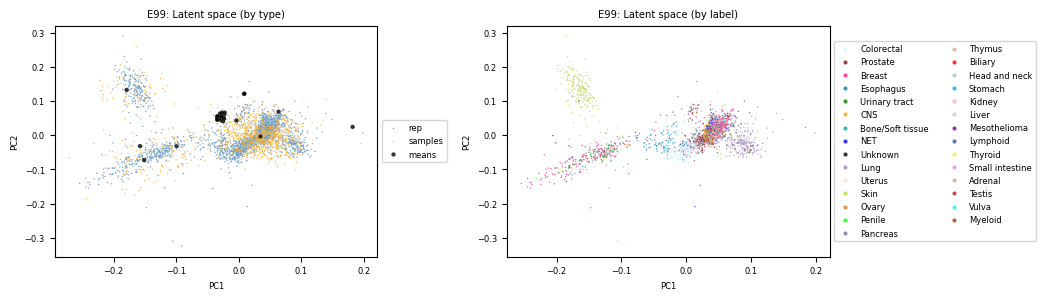

200 4.526379306263243 4.534092536059127


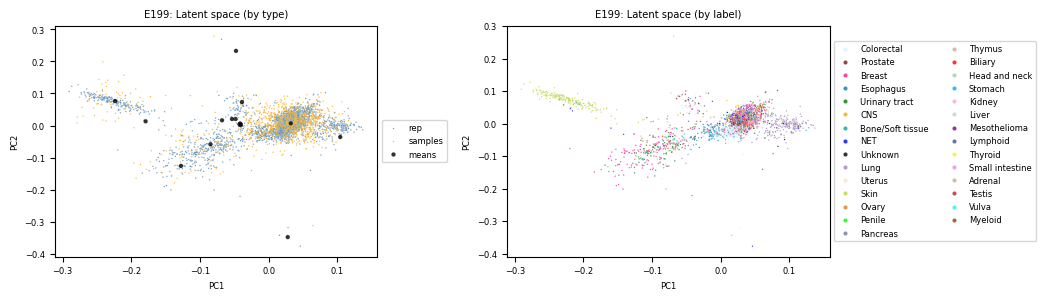

300 4.467913486992595 4.482814872617822


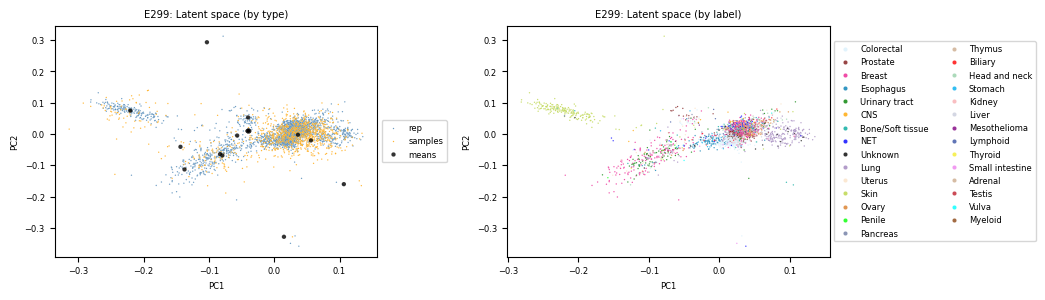

400 4.447733517787421 4.4762144188940125


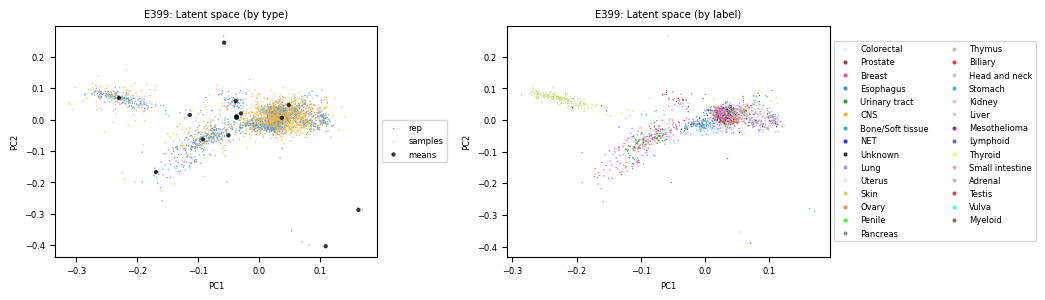

500 4.4431463669351405 4.462854423632253


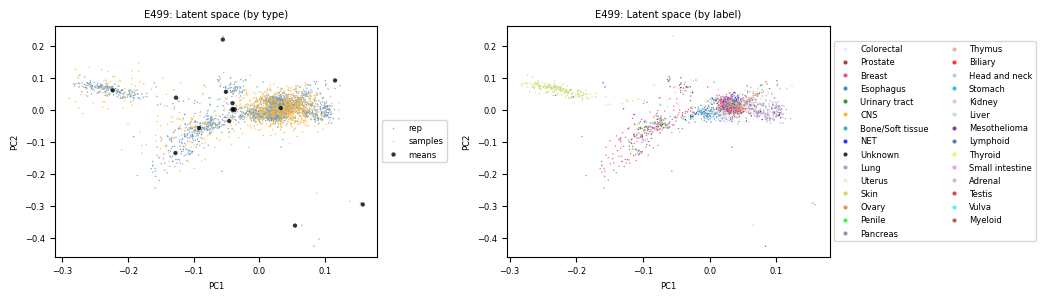

600 4.436225395510128 4.455418161357599


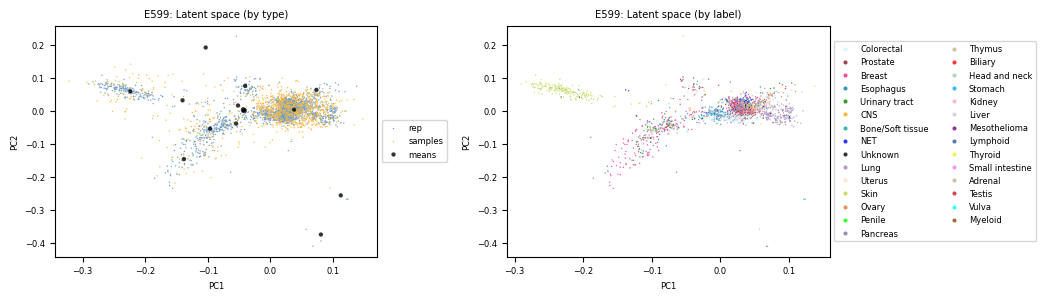

700 4.433118897063181 4.455219782525967


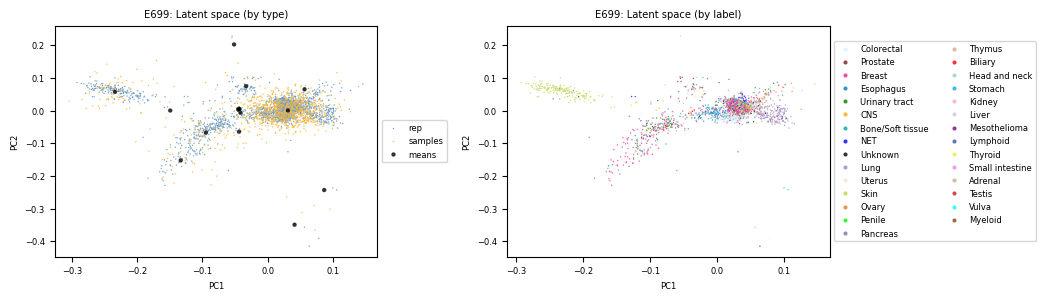

800 4.428980118745647 4.458913196465347


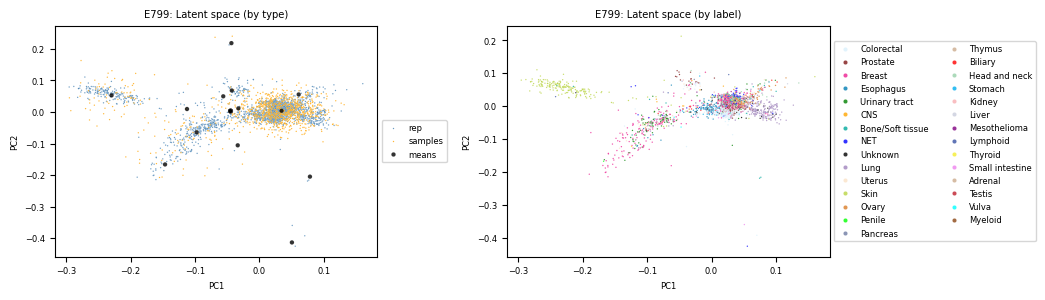

900 4.426131304998203 4.447379213349525


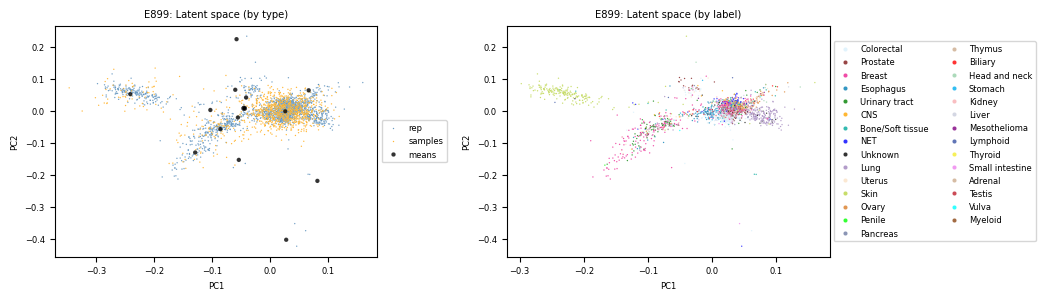

1000 4.421489283279991 4.451879025871911


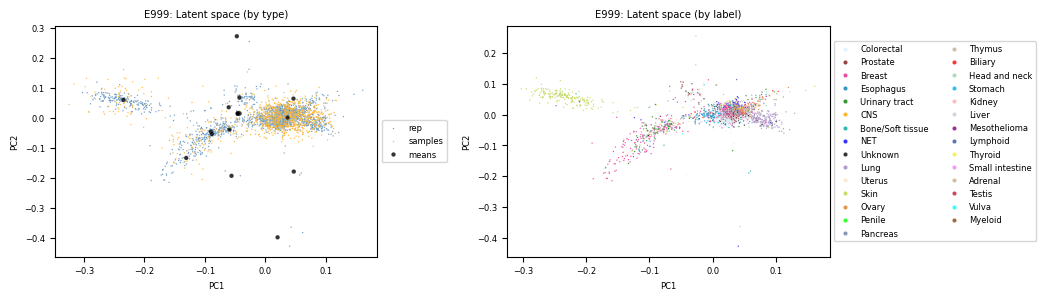

In [188]:
# train for x epochs and plot learning curves
n_epochs = 1000
pr = 100 # how often to print
plot = 100

loss_tab = train_dgd(
    dgd, train_loader, validation_loader, device, 
    learning_rates={'dec':0.001,'rep':0.01,'gmm':0.01},
    weight_decay=0.,nepochs=n_epochs,pr=pr,plot=plot,reduction_type=reduction_type
    )

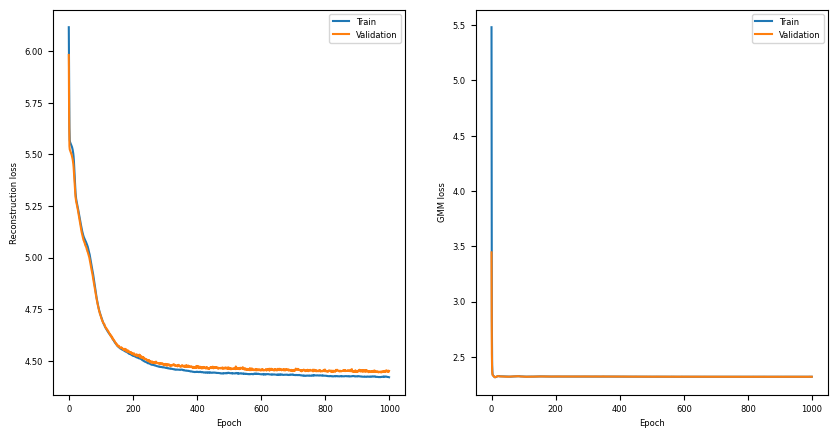

In [189]:
# make 2 subplots with recon and gmm loss curves
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(loss_tab["Epoch"],loss_tab["Train recon"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["Test recon"],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(loss_tab["Epoch"],loss_tab["GMM train"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["GMM test"],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")
plt.legend()
plt.show()

In [37]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=5, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
    )
    (out_modules): ModuleList(
      (0): NB_Module(
        (fc): Sequential(
          (0): Linear(in_features=20, out_features=96, bias=True)
        )
      )
    )
  )
  (gmm): GaussianMixture()
  (train_rep): RepresentationLayer()
  (val_rep): RepresentationLayer()
)

In [38]:
# save the trained model
torch.save(dgd, "dgd_model_sum.pth")

# Test representation

In [39]:
dgd_model = torch.load("dgd_model_sum.pth")

/tmp/52244098/ipykernel_825231/2750425019.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dgd_model = torch.load("dgd_model_sum.pth")


In [40]:
dgd_model

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=5, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
    )
    (out_modules): ModuleList(
      (0): NB_Module(
        (fc): Sequential(
          (0): Linear(in_features=20, out_features=96, bias=True)
        )
      )
    )
  )
  (gmm): GaussianMixture()
  (train_rep): RepresentationLayer()
  (val_rep): RepresentationLayer()
)

In [41]:
# take test part of mut_data
#test_data = mut_data.loc[X_test.index]
test_data

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T,primaryTumorLocation
2963,188,158,22,100,125,84,24,114,133,91,...,287,124,62,81,282,337,95,106,430,Lymphoid
3194,2674,2234,894,1610,1688,1429,809,1508,1706,1279,...,1013,804,731,1213,1344,1420,1288,1582,2612,Uterus
3004,110,46,8,53,65,43,10,56,76,33,...,17,7,4,26,15,10,9,25,51,Ovary
479,443,310,21,480,706,1251,305,3043,209,356,...,669,45,81,256,544,116,130,354,1791,Prostate
1008,119,87,15,52,61,61,11,49,56,42,...,26,16,15,40,27,16,15,42,68,Urinary tract
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,121,85,9,63,72,63,26,68,76,44,...,45,20,21,45,21,48,19,64,115,Breast
31,220,144,26,135,235,120,35,183,224,93,...,79,25,21,50,55,52,33,61,125,Prostate
3410,70,57,7,34,35,34,13,40,44,29,...,22,6,14,25,19,15,15,29,35,Head and neck
2384,139,102,16,93,109,54,9,86,159,53,...,30,9,13,28,23,35,21,33,66,Biliary


In [42]:
test_loader = torch.utils.data.DataLoader(GeneExpressionDataset(test_data, scaling_type="sum"), # default is scaling_type='mean'
                                          batch_size=64,
                                          shuffle=False)

In [43]:
see_test = GeneExpressionDataset(test_data)
see_test

In [44]:
# Access the first sample (idx=0)
mutations, lib, idx = see_test[0] 

# Print the results
print("Mutations:", mutations)
print("Library Size (lib):", lib)
print("Index:", idx)

Mutations: tensor([188., 158.,  22., 100., 125.,  84.,  24., 114., 133.,  91.,  18.,  88.,
        175.,  68.,  17., 296., 104.,  51.,  13.,  95.,  46.,  39.,  11.,  52.,
         43.,  44.,  10.,  66.,  81.,  65.,  10., 133., 282., 130., 475., 178.,
        195., 202., 342., 186., 164., 182., 406., 190., 221., 196., 219., 275.,
        269., 119., 109., 269.,  94.,  75.,  81., 101., 127., 185.,  87.,  91.,
        311.,  75., 112., 279., 353., 133., 211., 305., 151., 129., 186., 213.,
        192., 179., 210., 215., 209., 338., 117., 446., 312.,  76.,  83., 155.,
        148.,  68., 102., 287., 124.,  62.,  81., 282., 337.,  95., 106., 430.])
Library Size (lib): tensor(157.5625)
Index: 0


In [45]:
test_loader.dataset

In [46]:
new_rep = learn_new_representation(dgd_model, 
                             test_loader,
                             test_epochs=50,
                             learning_rates=1e-2, 
                             weight_decay=0.,
                             betas=(0.5, 0.7),
                             reduction_type="sum",
                             resampling_type="mean")

100%|██████████| 50/50 [00:00<00:00, 68.60it/s]


In [47]:
new_rep

RepresentationLayer()

In [48]:
dgd_model.train_rep

RepresentationLayer()

In [49]:
# assign the test representation from the predict function to the test_rep in the dgd model
dgd_model.test_rep = new_rep

In [50]:
dgd_test = dgd_model.get_representations(type="test")
dgd_test

array([[-1.57766808e-02,  3.95347103e-02, -2.47479547e-02,
        -3.30597162e-02, -7.30143711e-02],
       [-3.59454937e-02,  3.50421928e-02, -1.80892162e-02,
        -5.77950254e-02, -4.85995412e-02],
       [-4.16441471e-04, -4.14613932e-02, -9.89374518e-02,
        -1.70881469e-02, -1.45640537e-01],
       ...,
       [-2.33574882e-02, -1.36390328e-04, -6.56361654e-02,
        -3.17441113e-02, -1.23518184e-01],
       [-4.14873958e-02,  2.57848464e-02, -9.57730114e-02,
        -5.79332039e-02, -8.42677131e-02],
       [-2.81464420e-02,  1.25317574e-02,  3.26221287e-02,
        -2.63194945e-02, -5.55574615e-03]], dtype=float32)

In [51]:
# make df with latent variable column names
dgd_test_df = pd.DataFrame(dgd_test, columns=['L1', 'L2', 'L3', 'L4', 'L5'])
dgd_test_df

,L1,L2,L3,L4,L5
0,-0.015777,0.039535,-0.024748,-0.033060,-0.073014
1,-0.035945,0.035042,-0.018089,-0.057795,-0.048600
2,-0.000416,-0.041461,-0.098937,-0.017088,-0.145641
3,-0.020530,-0.001484,-0.033988,-0.119094,-0.089030
4,-0.029073,-0.012036,-0.069435,-0.028215,-0.123681
...,...,...,...,...,...
345,-0.065443,0.025991,-0.066618,-0.086840,-0.071566
346,-0.039362,0.059723,-0.013486,-0.005536,-0.025400
347,-0.023357,-0.000136,-0.065636,-0.031744,-0.123518
348,-0.041487,0.025785,-0.095773,-0.057933,-0.084268


In [52]:
test_data['primaryTumorLocation']

2963         Lymphoid
3194           Uterus
3004            Ovary
479          Prostate
1008    Urinary tract
            ...      
661            Breast
31           Prostate
3410    Head and neck
2384          Biliary
2308            Ovary
Name: primaryTumorLocation, Length: 350, dtype: object

In [53]:
# add original indices
dgd_test_df.index = test_data.index
dgd_test_df

,L1,L2,L3,L4,L5
2963,-0.015777,0.039535,-0.024748,-0.033060,-0.073014
3194,-0.035945,0.035042,-0.018089,-0.057795,-0.048600
3004,-0.000416,-0.041461,-0.098937,-0.017088,-0.145641
479,-0.020530,-0.001484,-0.033988,-0.119094,-0.089030
1008,-0.029073,-0.012036,-0.069435,-0.028215,-0.123681
...,...,...,...,...,...
661,-0.065443,0.025991,-0.066618,-0.086840,-0.071566
31,-0.039362,0.059723,-0.013486,-0.005536,-0.025400
3410,-0.023357,-0.000136,-0.065636,-0.031744,-0.123518
2384,-0.041487,0.025785,-0.095773,-0.057933,-0.084268


In [54]:
# add tissue, the sample order is preserved
dgd_test_df['primaryTumorLocation'] = test_data['primaryTumorLocation']
dgd_test_df

,L1,L2,L3,L4,L5,primaryTumorLocation
2963,-0.015777,0.039535,-0.024748,-0.033060,-0.073014,Lymphoid
3194,-0.035945,0.035042,-0.018089,-0.057795,-0.048600,Uterus
3004,-0.000416,-0.041461,-0.098937,-0.017088,-0.145641,Ovary
479,-0.020530,-0.001484,-0.033988,-0.119094,-0.089030,Prostate
1008,-0.029073,-0.012036,-0.069435,-0.028215,-0.123681,Urinary tract
...,...,...,...,...,...,...
661,-0.065443,0.025991,-0.066618,-0.086840,-0.071566,Breast
31,-0.039362,0.059723,-0.013486,-0.005536,-0.025400,Prostate
3410,-0.023357,-0.000136,-0.065636,-0.031744,-0.123518,Head and neck
2384,-0.041487,0.025785,-0.095773,-0.057933,-0.084268,Biliary


In [55]:
# save test reps for KNN
dgd_test_df.to_csv('dgd_test_df_sum.tsv', sep='\t', index=True)

In [56]:
print(dgd_model.test_rep)


        RepresentationLayer:
            Dimensionality: 5
            Number of samples: 350
            Value initialization: custom
        


# Train/val rep df for KNN

In [57]:
# check the saved coordinates are the same, they are
dgd_train = dgd_model.get_representations(type="train")
dgd_train

array([[-0.05455169,  0.03739282, -0.09894547, -0.04807917, -0.10328794],
       [-0.06281257,  0.04513442, -0.08332872, -0.08868838, -0.10495962],
       [-0.06296789,  0.0647946 , -0.05743489, -0.09658162, -0.04979948],
       ...,
       [-0.03846095,  0.05445328, -0.06603588, -0.07297278, -0.08330307],
       [-0.05860602,  0.05244884, -0.08476831, -0.0875775 , -0.07776973],
       [-0.06845769,  0.05305184, -0.10142905, -0.07175723, -0.11177407]],
      dtype=float32)

In [58]:
# make df with latent variable column names
dgd_train_df = pd.DataFrame(dgd_train, columns=['L1', 'L2', 'L3', 'L4', 'L5'])
dgd_train_df

,L1,L2,L3,L4,L5
0,-0.054552,0.037393,-0.098945,-0.048079,-0.103288
1,-0.062813,0.045134,-0.083329,-0.088688,-0.104960
2,-0.062968,0.064795,-0.057435,-0.096582,-0.049799
3,-0.041960,0.009954,-0.080507,-0.058164,-0.099944
4,-0.034919,-0.015890,-0.068074,-0.042203,-0.062537
...,...,...,...,...,...
2807,-0.068677,0.057177,-0.060349,-0.088972,-0.087542
2808,-0.109005,-0.023262,-0.073837,-0.064499,-0.053765
2809,-0.038461,0.054453,-0.066036,-0.072973,-0.083303
2810,-0.058606,0.052449,-0.084768,-0.087577,-0.077770


In [59]:
# see original indices
train_data

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T,primaryTumorLocation
266,282,235,27,163,239,159,31,245,244,176,...,1256,21,39,43,282,135,55,87,536,Colorectal
1704,116,58,10,54,72,52,13,47,79,40,...,16,12,9,31,13,24,10,21,58,Prostate
850,77,58,8,47,55,47,9,46,56,43,...,23,10,12,23,11,22,9,33,56,Breast
2219,360,197,31,187,235,141,22,233,318,139,...,2338,36,27,90,599,125,95,132,1033,Esophagus
704,237,581,33,240,253,178,41,280,281,323,...,1699,32,94,67,421,141,129,150,880,Urinary tract
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,78,61,10,50,68,43,11,33,36,40,...,28,13,14,36,32,25,14,29,79,Breast
689,96,65,11,65,59,51,10,56,61,48,...,27,16,11,40,35,50,23,41,81,Breast
1690,190,137,25,132,174,135,37,154,145,92,...,78,22,28,76,75,60,36,86,151,Head and neck
2851,123,98,14,65,101,74,16,86,108,66,...,26,20,13,23,24,38,25,34,61,Breast


In [60]:
# add original indices
dgd_train_df.index = train_data.index
dgd_train_df

,L1,L2,L3,L4,L5
266,-0.054552,0.037393,-0.098945,-0.048079,-0.103288
1704,-0.062813,0.045134,-0.083329,-0.088688,-0.104960
850,-0.062968,0.064795,-0.057435,-0.096582,-0.049799
2219,-0.041960,0.009954,-0.080507,-0.058164,-0.099944
704,-0.034919,-0.015890,-0.068074,-0.042203,-0.062537
...,...,...,...,...,...
3235,-0.068677,0.057177,-0.060349,-0.088972,-0.087542
689,-0.109005,-0.023262,-0.073837,-0.064499,-0.053765
1690,-0.038461,0.054453,-0.066036,-0.072973,-0.083303
2851,-0.058606,0.052449,-0.084768,-0.087577,-0.077770


In [61]:
# add tissue, the sample order is preserved
dgd_train_df['primaryTumorLocation'] = train_data['primaryTumorLocation']
dgd_train_df

,L1,L2,L3,L4,L5,primaryTumorLocation
266,-0.054552,0.037393,-0.098945,-0.048079,-0.103288,Colorectal
1704,-0.062813,0.045134,-0.083329,-0.088688,-0.104960,Prostate
850,-0.062968,0.064795,-0.057435,-0.096582,-0.049799,Breast
2219,-0.041960,0.009954,-0.080507,-0.058164,-0.099944,Esophagus
704,-0.034919,-0.015890,-0.068074,-0.042203,-0.062537,Urinary tract
...,...,...,...,...,...,...
3235,-0.068677,0.057177,-0.060349,-0.088972,-0.087542,Breast
689,-0.109005,-0.023262,-0.073837,-0.064499,-0.053765,Breast
1690,-0.038461,0.054453,-0.066036,-0.072973,-0.083303,Head and neck
2851,-0.058606,0.052449,-0.084768,-0.087577,-0.077770,Breast


Validation set

In [62]:
# DGD coordinates for validation data
dgd_val = dgd_model.get_representations(type="val")
dgd_val

array([[-0.05990165,  0.03226615, -0.09226383, -0.05755022, -0.10005242],
       [-0.01928949,  0.1245921 , -0.11349943, -0.07096742, -0.07650459],
       [-0.0492731 , -0.05325385, -0.11752786, -0.07894374, -0.05019373],
       ...,
       [-0.04158067, -0.10338808, -0.10584117, -0.0343239 , -0.04343339],
       [-0.06013065,  0.04794512, -0.07397528, -0.06798207, -0.07922848],
       [-0.07063372,  0.04573951, -0.10762642, -0.06681961, -0.09444309]],
      dtype=float32)

In [63]:
dgd_val_df = pd.DataFrame(dgd_val, columns=['L1', 'L2', 'L3', 'L4', 'L5'])
dgd_val_df

,L1,L2,L3,L4,L5
0,-0.059902,0.032266,-0.092264,-0.057550,-0.100052
1,-0.019289,0.124592,-0.113499,-0.070967,-0.076505
2,-0.049273,-0.053254,-0.117528,-0.078944,-0.050194
3,-0.055651,0.046592,-0.068966,-0.065626,-0.098083
4,-0.137134,-0.197974,0.024087,-0.075018,-0.035232
...,...,...,...,...,...
344,-0.062744,0.072189,-0.057001,-0.083085,-0.058635
345,-0.058140,-0.030965,-0.075971,-0.068987,-0.047823
346,-0.041581,-0.103388,-0.105841,-0.034324,-0.043433
347,-0.060131,0.047945,-0.073975,-0.067982,-0.079228


In [64]:
# add original index
dgd_val_df.index = validation_data.index
dgd_val_df

,L1,L2,L3,L4,L5
2590,-0.059902,0.032266,-0.092264,-0.057550,-0.100052
725,-0.019289,0.124592,-0.113499,-0.070967,-0.076505
512,-0.049273,-0.053254,-0.117528,-0.078944,-0.050194
1219,-0.055651,0.046592,-0.068966,-0.065626,-0.098083
2247,-0.137134,-0.197974,0.024087,-0.075018,-0.035232
...,...,...,...,...,...
2183,-0.062744,0.072189,-0.057001,-0.083085,-0.058635
1828,-0.058140,-0.030965,-0.075971,-0.068987,-0.047823
760,-0.041581,-0.103388,-0.105841,-0.034324,-0.043433
940,-0.060131,0.047945,-0.073975,-0.067982,-0.079228


In [65]:
dgd_val_df['primaryTumorLocation'] = validation_data['primaryTumorLocation']
dgd_val_df

,L1,L2,L3,L4,L5,primaryTumorLocation
2590,-0.059902,0.032266,-0.092264,-0.057550,-0.100052,Colorectal
725,-0.019289,0.124592,-0.113499,-0.070967,-0.076505,Unknown
512,-0.049273,-0.053254,-0.117528,-0.078944,-0.050194,Breast
1219,-0.055651,0.046592,-0.068966,-0.065626,-0.098083,Breast
2247,-0.137134,-0.197974,0.024087,-0.075018,-0.035232,Skin
...,...,...,...,...,...,...
2183,-0.062744,0.072189,-0.057001,-0.083085,-0.058635,Esophagus
1828,-0.058140,-0.030965,-0.075971,-0.068987,-0.047823,Breast
760,-0.041581,-0.103388,-0.105841,-0.034324,-0.043433,Urinary tract
940,-0.060131,0.047945,-0.073975,-0.067982,-0.079228,Breast


In [66]:
# merge and sort dfs
concat = pd.concat([dgd_train_df, dgd_val_df], axis=0)
concat

,L1,L2,L3,L4,L5,primaryTumorLocation
266,-0.054552,0.037393,-0.098945,-0.048079,-0.103288,Colorectal
1704,-0.062813,0.045134,-0.083329,-0.088688,-0.104960,Prostate
850,-0.062968,0.064795,-0.057435,-0.096582,-0.049799,Breast
2219,-0.041960,0.009954,-0.080507,-0.058164,-0.099944,Esophagus
704,-0.034919,-0.015890,-0.068074,-0.042203,-0.062537,Urinary tract
...,...,...,...,...,...,...
2183,-0.062744,0.072189,-0.057001,-0.083085,-0.058635,Esophagus
1828,-0.058140,-0.030965,-0.075971,-0.068987,-0.047823,Breast
760,-0.041581,-0.103388,-0.105841,-0.034324,-0.043433,Urinary tract
940,-0.060131,0.047945,-0.073975,-0.067982,-0.079228,Breast


In [67]:
merged_df = concat.sort_index(axis=0)
merged_df

,L1,L2,L3,L4,L5,primaryTumorLocation
1,-0.052436,0.068526,-0.068928,-0.087774,-0.097128,Unknown
2,-0.055782,0.054496,-0.046215,-0.083092,-0.069623,Breast
3,-0.023747,0.051987,-0.052186,-0.081376,-0.138118,NET
4,-0.030595,0.082673,-0.101583,-0.075296,-0.064529,Lung
5,-0.046722,0.072121,-0.064868,-0.045091,-0.087205,Breast
...,...,...,...,...,...,...
3511,-0.055987,-0.087518,-0.116339,-0.034618,-0.031708,Lung
3513,-0.062304,0.066438,-0.082357,-0.087383,-0.091533,Uterus
3514,-0.050495,0.062056,-0.070728,-0.041908,-0.096517,Bone/Soft tissue
3515,-0.034966,-0.033267,-0.041391,-0.117965,-0.127015,Colorectal


In [68]:
# save df for KNN
merged_df.to_csv('dgd_df_sum.tsv', sep='\t', index=True)

In [138]:
# reload
merged_df = pd.read_csv('dgd_df_sum.tsv', sep='\t')
merged_df

,Unnamed: 0,L1,L2,L3,L4,L5,primaryTumorLocation
0,1,-0.052436,0.068526,-0.068928,-0.087774,-0.097128,Unknown
1,2,-0.055782,0.054496,-0.046215,-0.083092,-0.069623,Breast
2,3,-0.023747,0.051987,-0.052186,-0.081376,-0.138118,NET
3,4,-0.030595,0.082673,-0.101583,-0.075296,-0.064529,Lung
4,5,-0.046722,0.072121,-0.064868,-0.045091,-0.087205,Breast
...,...,...,...,...,...,...,...
3156,3511,-0.055987,-0.087518,-0.116339,-0.034618,-0.031708,Lung
3157,3513,-0.062304,0.066438,-0.082357,-0.087383,-0.091534,Uterus
3158,3514,-0.050495,0.062056,-0.070728,-0.041908,-0.096517,Bone/Soft tissue
3159,3515,-0.034966,-0.033267,-0.041391,-0.117965,-0.127015,Colorectal


In [52]:
# the tissue from mut_data in the same index order as the merged_df
mut_data = mut_data.sort_index()
mut_data

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T,primaryTumorLocation
0,47,35,11,42,62,31,13,47,34,17,...,21,16,19,48,20,18,18,34,35,Bone/Soft tissue
1,107,73,17,71,77,91,16,78,42,67,...,46,10,22,25,24,24,13,41,43,Unknown
2,119,93,30,88,120,92,36,133,67,56,...,117,33,26,63,72,49,47,69,124,Breast
3,34,29,4,20,31,27,6,20,14,17,...,22,8,19,24,17,10,9,18,30,NET
4,595,304,135,373,622,532,150,512,390,298,...,65,21,11,56,37,63,31,59,126,Lung
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3512,1021,345,71,417,547,255,66,487,1381,293,...,6442,74,124,142,1572,233,179,257,2224,Esophagus
3513,89,72,18,57,57,53,17,69,72,48,...,26,14,10,16,23,32,18,25,70,Uterus
3514,148,111,21,108,92,113,15,105,70,59,...,185,24,18,38,41,71,33,39,132,Bone/Soft tissue
3515,1111,693,70,880,1664,2595,392,6491,1056,1893,...,7054,160,499,717,3671,574,509,1112,7067,Colorectal
